In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA


In [7]:
dataset=pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
dataset.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


# eda

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [9]:
dataset.isnull().sum()

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
dataset.shape

(282, 16)

In [12]:
dataset.describe()

,bytes_in,bytes_out,response.code,dst_port
count,2.820000e+02,2.820000e+02,282.0,282.0
mean,1.199390e+06,8.455429e+04,200.0,443.0
std,4.149312e+06,2.549279e+05,0.0,0.0
min,4.000000e+01,4.400000e+01,200.0,443.0
25%,5.381500e+03,1.114200e+04,200.0,443.0
50%,1.318200e+04,1.379950e+04,200.0,443.0
75%,3.083300e+04,2.627950e+04,200.0,443.0
max,2.520779e+07,1.561220e+06,200.0,443.0


In [13]:
print("bytes_in max values",dataset["bytes_in"].max())
print("bytes_in min values",dataset["bytes_in"].min())
print("bytes_in mean values",dataset["bytes_in"].mean())
print("bytes_in median values",dataset["bytes_in"].median())
print("")
print("bytes_out max values",dataset["bytes_out"].max())
print("bytes_out min values",dataset["bytes_out"].min())
print("bytes_out mean values",dataset["bytes_out"].mean())
print("bytes_out median values",dataset["bytes_out"].median())

bytes_in max values 25207794
bytes_in min values 40
bytes_in mean values 1199390.1914893617
bytes_in median values 13182.0

bytes_out max values 1561220
bytes_out min values 44
bytes_out mean values 84554.29078014185
bytes_out median values 13799.5


In [14]:
print("bytes_in skewness",dataset["bytes_in"].skew())
print("bytes_out skewness",dataset["bytes_out"].skew())

bytes_in skewness 4.245130066657025
bytes_out skewness 4.307309333695066


In [15]:
dataset["creation_time"]=pd.to_datetime(dataset["creation_time"])
dataset["end_time"]=pd.to_datetime(dataset["end_time"])
dataset["time"]=pd.to_datetime(dataset["time"])
dataset[["creation_time",'end_time',"time"]].tail(5)

,creation_time,end_time,time
277,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,2024-04-26 09:50:00+00:00
278,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,2024-04-26 09:50:00+00:00
279,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,2024-04-26 09:50:00+00:00
280,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,2024-04-26 09:50:00+00:00
281,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,2024-04-26 09:50:00+00:00


In [16]:
dataset["creation_timeT"]=dataset["creation_time"].dt.strftime('%H:%M:%S')
dataset["creation_timeD"]=dataset["creation_time"].dt.date
dataset["end_timeT"]=dataset["end_time"].dt.strftime('%H:%M:%S')
dataset["end_timeD"]=dataset["end_time"].dt.date
dataset["timeT"]=dataset["time"].dt.strftime('%H:%M:%S')
dataset["timeD"]=dataset["time"].dt.date

In [17]:
print('creation dates',dataset["creation_timeD"].value_counts())
print('end dates',dataset["end_timeD"].value_counts())
print('time dates',dataset["timeD"].value_counts())

creation dates creation_timeD
2024-04-26    224
2024-04-25     58
Name: count, dtype: int64
end dates end_timeD
2024-04-26    233
2024-04-25     49
Name: count, dtype: int64
time dates timeD
2024-04-26    224
2024-04-25     58
Name: count, dtype: int64


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [19]:
dataset[['protocol','response.code','dst_port' ,'dst_ip','rule_names','observation_name','source.meta','source.name']].value_counts()

protocol  response.code  dst_port  dst_ip        rule_names              observation_name                      source.meta   source.name   
HTTPS     200            443       10.138.69.97  Suspicious Web Traffic  Adversary Infrastructure Interaction  AWS_VPC_Flow  prod_webserver    282
Name: count, dtype: int64

In [20]:
(dataset['creation_time']==dataset['time']).sum()

282

In [21]:
dataset['src_ip_country_code'].value_counts()

src_ip_country_code
US    113
CA     72
DE     28
AT     21
NL     18
AE     16
IL     14
Name: count, dtype: int64

In [22]:
dataset.columns

Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types', 'creation_timeT',
       'creation_timeD', 'end_timeT', 'end_timeD', 'timeT', 'timeD'],
      dtype='object')

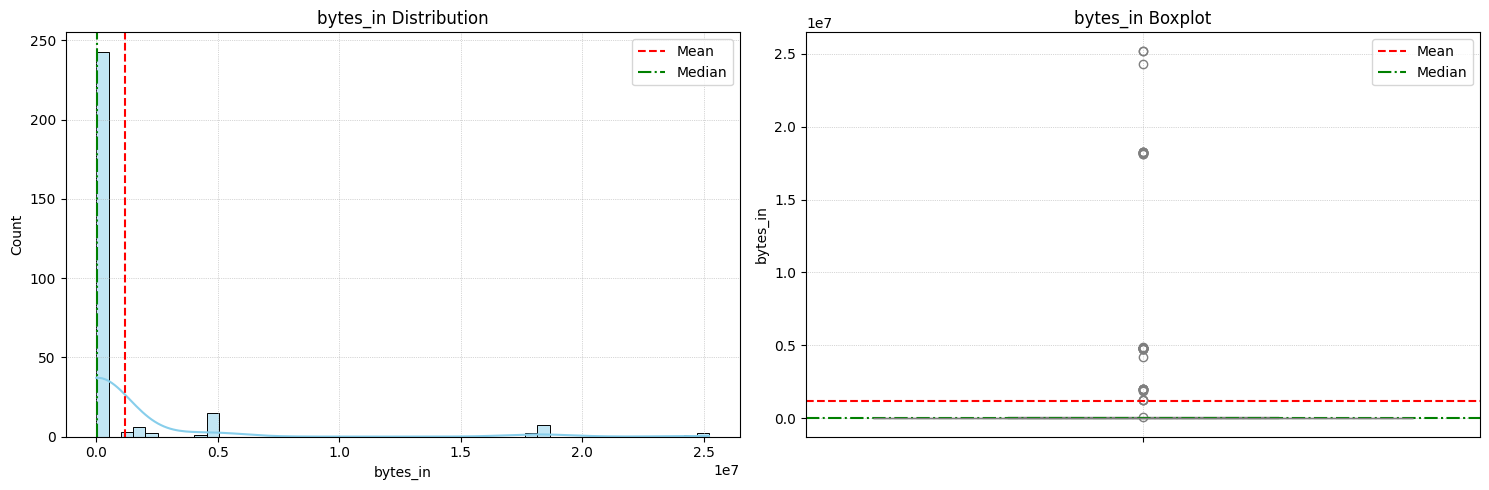

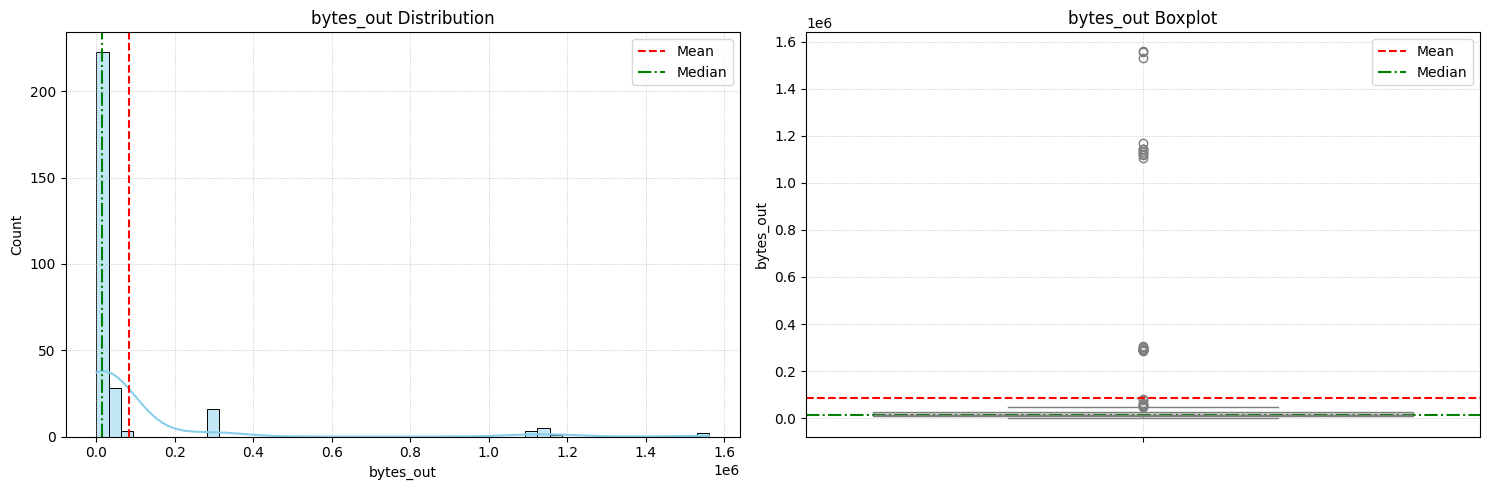

In [23]:
numeric_col = ['bytes_in', 'bytes_out']

for col in numeric_col:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(dataset[col], bins=50, kde=True, ax=ax[0], color='skyblue')
    mean_line = ax[0].axvline(dataset[col].mean(), color='red', linestyle='--', label='Mean')
    median_line = ax[0].axvline(dataset[col].median(), color='green', linestyle='-.', label='Median')
    ax[0].set_title(f"{col} Distribution")
    ax[0].grid(True, linestyle=':', linewidth=0.5)
    ax[0].legend()

    sns.boxplot(dataset[col], ax=ax[1], color='lightgray')
    ax[1].axhline(dataset[col].mean(), color='red', linestyle='--', label='Mean')
    ax[1].axhline(dataset[col].median(), color='green', linestyle='-.', label='Median')
    ax[1].set_title(f"{col} Boxplot")
    ax[1].grid(True, linestyle=':', linewidth=0.5)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

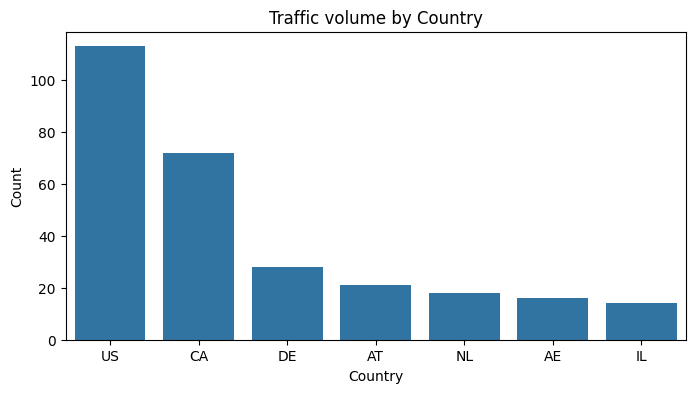

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(x='src_ip_country_code',data=dataset,order=dataset['src_ip_country_code'].value_counts().index)
plt.title("Traffic volume by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

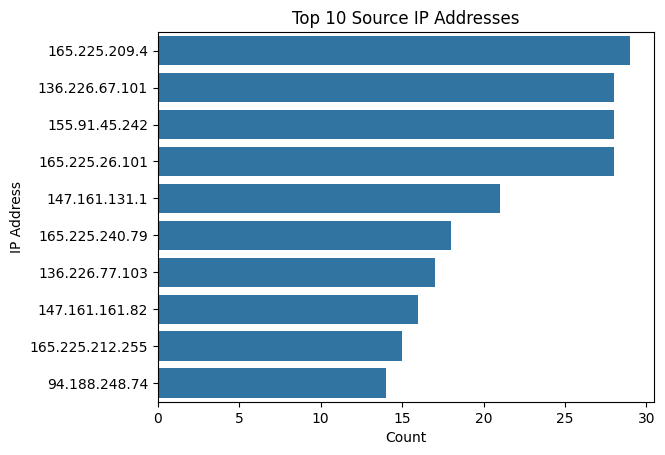

In [25]:
top_ips=dataset.value_counts('src_ip').head(10)
sns.barplot(y=top_ips.index,x=top_ips.values)
plt.title("Top 10 Source IP Addresses")
plt.xlabel("Count")
plt.ylabel("IP Address")
plt.show()

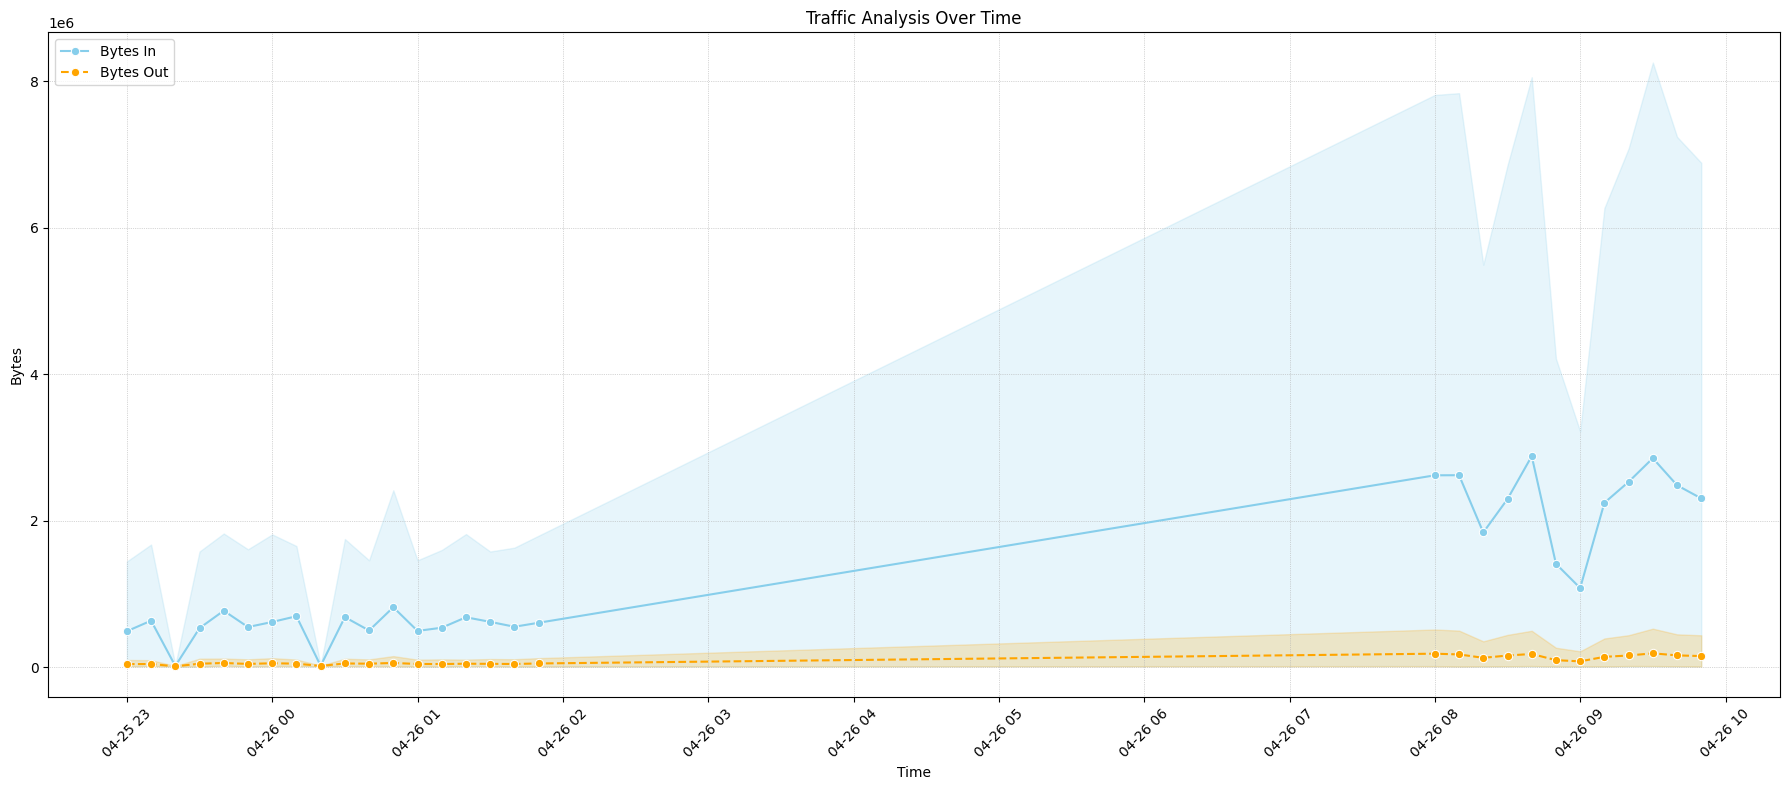

In [26]:
plt.figure(figsize=(18,8))
sns.lineplot(x='time',y= dataset['bytes_in'],data=dataset ,label='Bytes In', color='skyblue', marker='o', linestyle='-')
sns.lineplot(x='time',y= dataset['bytes_out'],data=dataset, label='Bytes Out', color='orange', marker='o', linestyle='--')
plt.title('Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


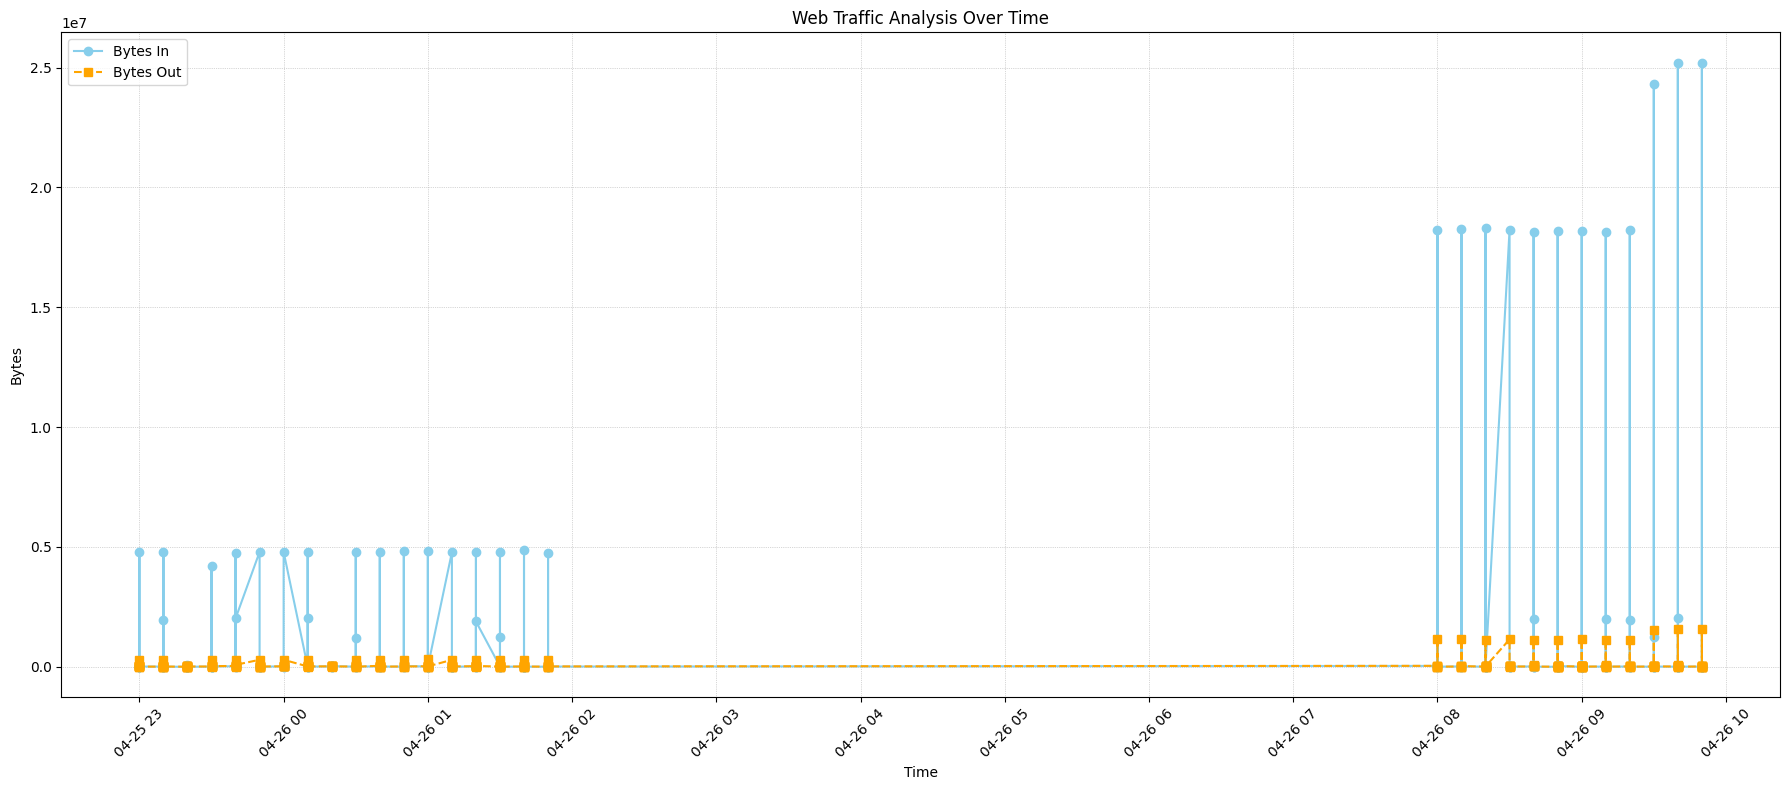

In [27]:
import matplotlib.pyplot as plt

dataset['time'] = pd.to_datetime(dataset['time'])
dataset.sort_values('time', inplace=True)

plt.figure(figsize=(18, 8))

plt.plot(dataset['time'], dataset['bytes_in'], label='Bytes In', color='skyblue', marker='o', linestyle='-')
plt.plot(dataset['time'], dataset['bytes_out'], label='Bytes Out', color='orange', marker='s', linestyle='--')

plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


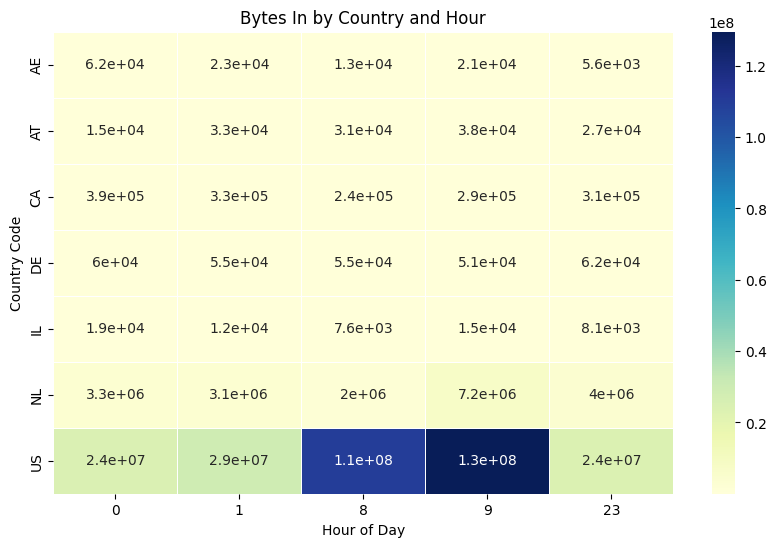

In [28]:
dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
heatmap_data = dataset.groupby(['src_ip_country_code', 'hour'])['bytes_in'].sum().unstack().fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=True)
plt.title('Bytes In by Country and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Country Code')
plt.show()


In [29]:
dataset['duration']=(dataset['end_time']-dataset['creation_time']).dt.total_seconds()
dataset["traffic_ratio"]=dataset['bytes_in']/(dataset['bytes_out']+1e-6)
dataset['total_per_second'] = (dataset['bytes_in'] + dataset['bytes_out']) / dataset['duration']
dataset['suspicion'] = dataset['detection_types'].apply(lambda x: 1 if x == 'waf_rule' else 0)
dataset['time_in_seconds']=pd.to_datetime(dataset['time']).dt.hour*3600+pd.to_datetime(dataset['time']).dt.minute*60+pd.to_datetime(dataset['time']).dt.second

In [30]:
dataset[['time_in_seconds','time']].head()

,time_in_seconds,time
0,82800,2024-04-25 23:00:00+00:00
1,82800,2024-04-25 23:00:00+00:00
2,82800,2024-04-25 23:00:00+00:00
3,82800,2024-04-25 23:00:00+00:00
4,82800,2024-04-25 23:00:00+00:00


In [31]:
drop_cols = ['src_ip', 'detection_types', 'creation_timeD', 'end_timeD', 'timeD',
             'protocol', 'response.code', 'dst_port', 'dst_ip','end_time', 'creation_time','hour',
             'creation_timeT', 'end_timeT', 'timeT','creation_timeD', 'end_timeD', 'timeD','time',
             'rule_names', 'observation_name', 'source.meta', 'source.name','detection_types','src_ip_country_code']
dataset.drop(columns=drop_cols, inplace=True)

In [32]:
dataset.head()

,bytes_in,bytes_out,duration,traffic_ratio,total_per_second,suspicion,time_in_seconds
0,5602,12990,600.0,0.431255,30.986667,1,82800
1,30912,18186,600.0,1.699769,81.830000,1,82800
2,28506,13468,600.0,2.116573,69.956667,1,82800
3,30546,14278,600.0,2.139375,74.706667,1,82800
4,6526,13892,600.0,0.469767,34.030000,1,82800


In [33]:
train_data=dataset.copy()
train_data.drop(columns=['suspicion'],inplace=True)
features=['bytes_in', 'bytes_out', 'duration', 'traffic_ratio', 'total_per_second', 'time_in_seconds']
pt=PowerTransformer(method='yeo-johnson')
train_data[features]=pt.fit_transform(train_data[features])

In [34]:
train_data.head()

,bytes_in,bytes_out,duration,traffic_ratio,total_per_second,time_in_seconds
0,-0.578842,-0.166438,0.0,-1.002349,-0.412098,1.343184
1,0.299021,0.067089,0.0,0.381783,0.222812,1.343184
2,0.262347,-0.141101,0.0,0.592222,0.129175,1.343184
3,0.293659,-0.100283,0.0,0.602136,0.168813,1.343184
4,-0.490724,-0.119417,0.0,-0.925534,-0.345001,1.343184


In [35]:
data=pd.DataFrame()
iso=IsolationForest(contamination=0.05,random_state=42)
data['iso_flag']=iso.fit_predict(train_data)

In [36]:
dbscan=DBSCAN(eps=0.5,min_samples=5)
data['dbscan_flag']=dbscan.fit_predict(train_data)

In [37]:
ocsvm=OneClassSVM(kernel='rbf',gamma='scale',nu=0.05)
data['svm_flag']=ocsvm.fit_predict(train_data)

In [38]:
lof=LocalOutlierFactor(n_neighbors=20,contamination=0.05)
data['lof_flag']=lof.fit_predict(train_data)

In [39]:
for col in ['iso_flag', 'dbscan_flag', 'svm_flag', 'lof_flag']:
    data[col] = data[col].apply(lambda x: 1 if x == -1 else 0)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_data)
data['pca1'] = pca_result[:, 0]
data['pca2'] = pca_result[:, 1]

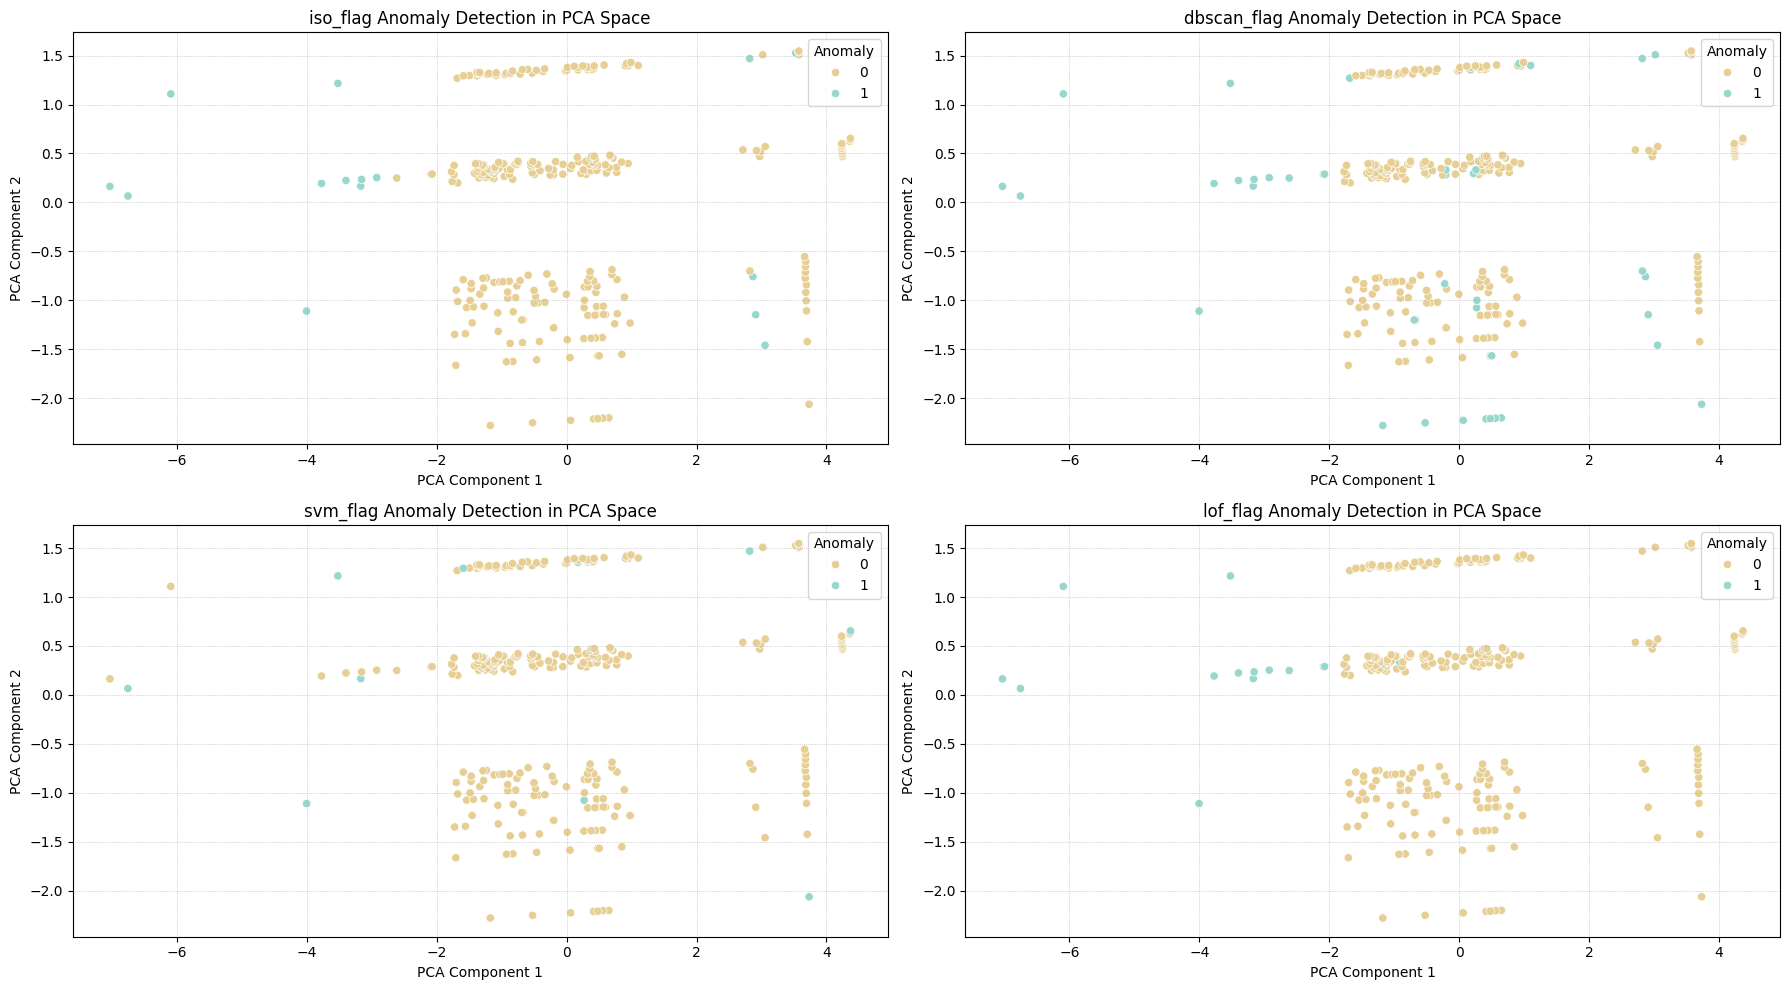

In [40]:


fig,ax=plt.subplots(2,2,figsize=(18,10))
ax=ax.flatten()
for i, col in enumerate(['iso_flag', 'dbscan_flag', 'svm_flag', 'lof_flag']):
    sns.scatterplot(x='pca1', y='pca2', hue=col, palette='BrBG', data=data, ax=ax[i])
    ax[i].set_title(f'{col} Anomaly Detection in PCA Space')
    ax[i].set_xlabel('PCA Component 1')
    ax[i].set_ylabel('PCA Component 2')
    ax[i].legend(title='Anomaly')
    ax[i].grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


In [41]:
model_flags = ['iso_flag', 'dbscan_flag', 'svm_flag', 'lof_flag']
data['ensemble_flag'] = data[model_flags].sum(axis=1).apply(lambda x: 1 if x >= 3 else 0)


In [42]:
for col in ['iso_flag', 'dbscan_flag', 'svm_flag', 'lof_flag', 'ensemble_flag']:
    print(f"{col} Anomaly Count: {data[col].sum()}")

iso_flag Anomaly Count: 15
dbscan_flag Anomaly Count: 42
svm_flag Anomaly Count: 11
lof_flag Anomaly Count: 15
ensemble_flag Anomaly Count: 11


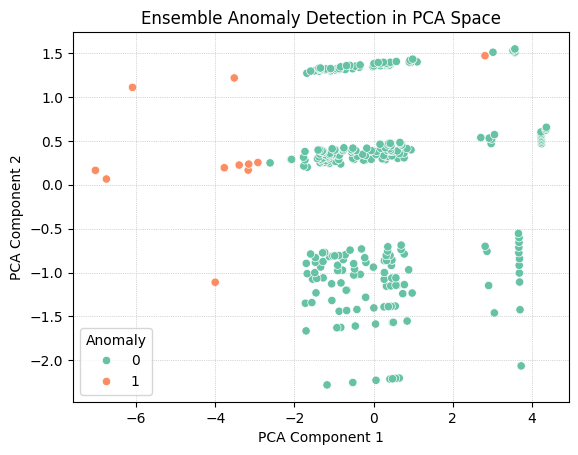

In [43]:
sns.scatterplot(x='pca1', y='pca2', hue='ensemble_flag', palette='Set2', data=data)
plt.title('Ensemble Anomaly Detection in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(title='Anomaly')
plt.show()


In [44]:
matched = ((dataset['suspicion'] == 1) & (data['ensemble_flag'] == 1)).sum()
total = dataset['suspicion'].sum()
print(f"Model flagged {matched} out of {total} suspicious entries as anomalous")


Model flagged 11 out of 282 suspicious entries as anomalous


In [45]:
X = train_data[['bytes_in', 'bytes_out', 'duration', 'traffic_ratio', 'total_per_second', 'time_in_seconds']]
y = data['ensemble_flag']


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(6, input_dim=6, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')


In [47]:
model.fit(X, y, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7764
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7095 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6288 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5978 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5675 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5301 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4900 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4417 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4129 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3708 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3386 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3200 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2706 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [48]:
y_pred_prob = model.predict(X).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.9929078014184397
Precision: 1.0
Recall: 0.8181818181818182
F1 Score: 0.9
Confusion Matrix:
 [[271   0]
 [  2   9]]


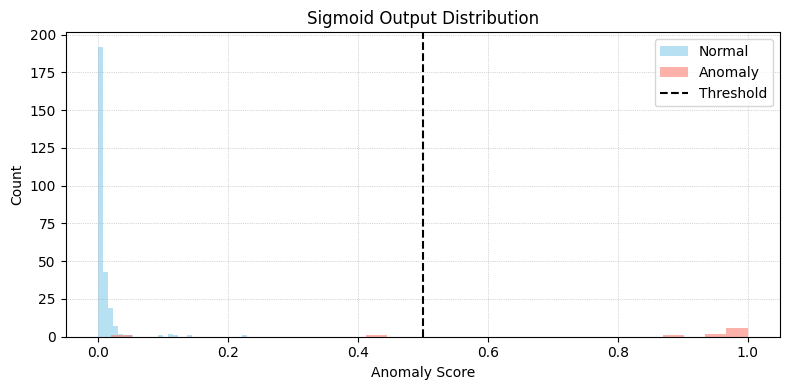

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.hist(y_pred_prob[y == 0], bins=30, alpha=0.6, label='Normal', color='skyblue')
plt.hist(y_pred_prob[y == 1], bins=30, alpha=0.6, label='Anomaly', color='salmon')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold')
plt.title("Sigmoid Output Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


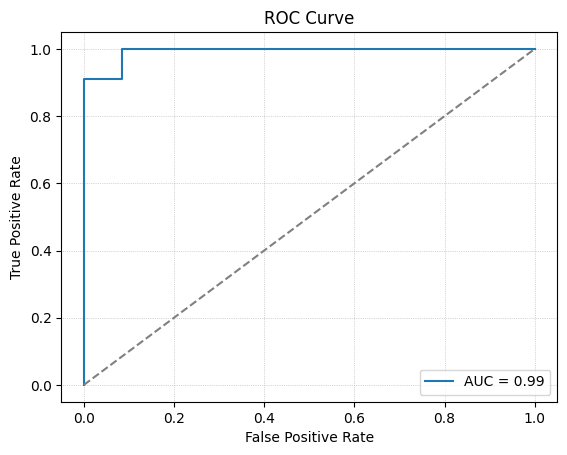

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
auc = roc_auc_score(y, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5)
plt.show()


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = (y_pred_prob > 0.45).astype(int)

print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))


Accuracy: 0.9929078014184397
Precision: 1.0
Recall: 0.8181818181818182
F1 Score: 0.9
Confusion Matrix:
 [[271   0]
 [  2   9]]


In [52]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y, y_pred_prob)
print("AUC Score:", auc)


AUC Score: 0.9922844682992285


In [53]:
data['nn_flag'] = (y_pred_prob > 0.45).astype(int)

In [54]:
model_flags = ['iso_flag', 'svm_flag', 'nn_flag']
data['ensemble_flag_3model'] = data[model_flags].sum(axis=1).apply(lambda x: 1 if x >= 2 else 0)

In [55]:
matched = ((dataset['suspicion'] == 1) & (data['ensemble_flag_3model'] == 1)).sum()
total = dataset['suspicion'].sum()
print(f"Model flagged {matched} out of {total} suspicious entries as anomalous")

Model flagged 10 out of 282 suspicious entries as anomalous


model saved

In [56]:
import joblib

joblib.dump(pt, 'model_resources/power_transformer.pkl')

joblib.dump(iso, 'model_resources/iso_model.pkl')

joblib.dump(ocsvm, 'model_resources/svm_model.pkl')

model.save('model_resources/anomaly_nn_model.h5')
